In [1]:
import os, sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

# Define some funtions

In [10]:
def Std(dataframe):
    values = np.array(dataframe.values)
    values_norm = [(x-np.mean(x))/(np.std(x)+0.00000000001) for x in values]
    dataframe_std = pd.DataFrame(values_norm, columns = dataframe.columns, index = dataframe.index)
    return(dataframe_std)

#------------------------

# don't understand X_std > X_scale
def normalize(X, Max, Min):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (Max - Min) + Min
    return X_scaled

#------------------------

def getList(dict): 
      return [*dict]


# define some functions


# get rid of incorrect neuron and non-target neuron for trace file
#----------------------------------------------------------------------------------
def process_(trace_path, incorrect_neuron_path, position_path):
    
    #read csv
    df = pd.read_csv(trace_path).iloc[1:]
    
    #profecc column in df file
    column_list = df.columns.tolist()
    column_list = [column.strip() for column in column_list]
    column_list[0] = 'Frame'
    df.columns = column_list
    
    # drop the first row, cell-undecide
    #df =df.drop([0])
    
    #read and process incorrect neuron list
    with open(incorrect_neuron_path) as f:
        df_in_list = [line.rstrip('\n') for line in open(incorrect_neuron_path)]
    
    #fix 78 to 078
    new_df_in_list = []
    for i in df_in_list:
        if len(i) < 3:
            sup0 = '0'*(3-len(i))
            i = sup0+i
        new_df_in_list.append(i)
        
    new_df_in_list = ["C" + neuron for neuron in new_df_in_list]
    #print('%i neurons are not correct'%len(new_df_in_list))
    
    # get cells that are not our target
    position = pd.read_csv(position_path, names =['x','y','L'] )
    position['C'] = df.columns[1:]
    position_no = position[(position['L'] == 0)]
    position_no_c_list = position_no['C'].values.tolist()
    #print('%i neurons are not our target'%len(position_no_c_list))

    # merge incorrect neuron list and non-target neuron list
    non_list = list(set(new_df_in_list+position_no_c_list))
    #print('%i neurons are removing'%len(non_list))
    #print(' ')
    # rule out incorrect neurons
    df = df.drop(columns = non_list)


    #convert object dtype to float
    df = df.astype('float')
    
    #set Frame as index
    df = df.set_index('Frame')
    return(df)

#------------------------

#three sessions
#use separate_session(df)[0/1/2] to get each session
def separate_session(df):
    
    check_point = []

    frame_list = df.index.values.tolist()

    for i in range(len(df)):
        if i < len(df)-1:
            if (frame_list[i+1] - frame_list[i]) > 3:
                check_point.append(frame_list[i+1])


    # separate
    df_1 = df[df.index < check_point[0] ]
    df_2 = df[(df.index < check_point[1]) & (df.index >= check_point[0] ) ]
    df_3 = df[df.index >= check_point[1]]


    print('The df shape of session 1:',df_1.shape)
    print('The df shape of session 2:',df_2.shape)
    print('The df shape of session 3:',df_3.shape)

    return(df_1,df_2,df_3)


#function to get label array
#------------------------

def process_label(Label_list):
    label = pd.read_csv(Label_list, names = 'Label')
    label = label[['L']]
    label.columns = ['Label']
    labels = label.values
    return(labels)

In [11]:
# process frame list
# event file always start from 10.1s, but some trace frame start from 0, some from 741.19
#----------------------------------------------------------------------------------

def process_frame(df):
    # get frame list
    frame_list = df.index.values.tolist()
    
    for i in frame_list:
        if i != 0:
            a = i-0
        else:
            a = 0
        break
        return(a)
        break

    new_frame_list = [(i-a) for i in frame_list]
    
    return(new_frame_list)


# process event_label list
# event+label starts from 10, but trace start from 0, deduct 10 from event_start&end time
#----------------------------------------------------------------------------------
def process_event_interval(df):
    event_list = df[['From Second','To Second']].values.tolist()
    new_event_list = []
    for event in event_list:
        new_event = [x -10.01 for x in event]
        new_event_list.append(new_event)
    return(new_event_list)


    
# get enevt label for an event file based on different mice and session
# for each session, we have separate event file
#----------------------------------------------------------------------------------
def get_event_label(event_df_1, event_df_2, event_df_3, mice_path):
    
    #get mice
    mice = os.path.basename(mice_path).split('_')[0]    
    # get event status list
    Event_status_1 = event_df_1['Event'].values.tolist()
    Event_status_2 = event_df_2['Event'].values.tolist()
    Event_status_3 = event_df_3['Event'].values.tolist()
    Event_status_list = [Event_status_1, Event_status_2, Event_status_3]
    # compact event label list for three sessions
    event_label_1 = []
    event_label_2 = []
    event_label_3 = []
    event_label_list = [event_label_1,event_label_2,event_label_3]

    
    if mice in ['NC128', 'NC139', 'NC297', 'NC298', 'NC308', 'NC314', 'NC315', 'NC463', 'NC476',
            'NC102', 'NC103', 'NC114', 'NC296', 'NC313', 'NC462', 'NC464', 'NC468', 'NC475']:
        for i in Event_status_1:   
            if i == 'Mouse 1 sniffing On s1':
                event_label_1.append(11)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_1.append(12)
            elif i == 'Mouse 1 Grooming':
                event_label_1.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_1.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_1.append(21)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_1.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_1.append(23)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_1.append(31)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_1.append(32)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_1.append(41)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_1.append(42)

            else:
                event_label_1.append(0)

        for i in Event_status_2:  
            if i == 'Mouse 1 sniffing On s1':
                event_label_2.append(12)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_2.append(11)
            elif i == 'Mouse 1 Grooming':
                event_label_2.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_2.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_2.append(23)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_2.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_2.append(21)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_2.append(32)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_2.append(31)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_2.append(42)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_2.append(41)

            else:
                event_label_2.append(0)  
                
        for i in Event_status_3:   
            if i == 'Mouse 1 sniffing On s1':
                event_label_3.append(11)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_3.append(12)
            elif i == 'Mouse 1 Grooming':
                event_label_3.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_3.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_3.append(21)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_3.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_3.append(23)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_3.append(31)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_3.append(32)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_3.append(41)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_3.append(42)

            else:
                event_label_3.append(0)
    
    #if other mice, just the opposite situation
    else:
        for i in Event_status_2:   
            if i == 'Mouse 1 sniffing On s1':
                event_label_2.append(11)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_2.append(12)
            elif i == 'Mouse 1 Grooming':
                event_label_2.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_2.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_2.append(21)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_2.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_2.append(23)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_2.append(31)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_2.append(32)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_2.append(41)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_2.append(42)

            else:
                event_label_2.append(0)
                    
        for i in Event_status_1:  
            if i == 'Mouse 1 sniffing On s1':
                event_label_1.append(12)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_1.append(11)
            elif i == 'Mouse 1 Grooming':
                event_label_1.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_1.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_1.append(23)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_1.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_1.append(21)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_1.append(32)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_1.append(31)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_1.append(42)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_1.append(41)

            else:
                event_label_1.append(0) 


        for i in Event_status_3:  
            if i == 'Mouse 1 sniffing On s1':
                event_label_3.append(12)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_3.append(11)
            elif i == 'Mouse 1 Grooming':
                event_label_3.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_3.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_3.append(23)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_3.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_3.append(21)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_3.append(32)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_3.append(31)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_3.append(42)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_3.append(41)

            else:
                event_label_3.append(0)
                
    return(event_label_1, event_label_2, event_label_3)
    
    
# process events file, add event label for string label
#----------------------------------------------------------------------------------
def add_event_label(trace_df, event_1_path, event_2_path, event_3_path, mice_path):
       
    # get separate sessions
    df_1,df_2,df_3 = separate_session(trace_df)
    # get df1, df2, df3 frame time list
    frame_list_1 = process_frame(df_1)
    frame_list_2 = process_frame(df_2)
    frame_list_3 = process_frame(df_3)
    #get event dataframe
    event_df_1 = pd.read_excel(event_1_path, skiprows = 6)
    event_df_2 = pd.read_excel(event_2_path, skiprows = 6)
    event_df_3 = pd.read_excel(event_3_path, skiprows = 6)
    # get event intervals
    interval_list_1 = process_event_interval(event_df_1)
    interval_list_2 = process_event_interval(event_df_2)
    interval_list_3 = process_event_interval(event_df_3)
    # get event label
    event_label_1, event_label_2, event_label_3 = get_event_label(event_df_1, event_df_2, event_df_3, mice_path)

    # deal with session 1
    frame_label_list_1 = []
    for frame in frame_list_1:
        frame_label = str()
        
        #begin to define frame label
        for i in range(len(interval_list_1)):
            if min(interval_list_1[i])  <= frame <= max(interval_list_1[i]) :
                frame_label = frame_label+ str(event_label_1[i])

        # convert str to int
        if len(frame_label) == 0:
            frame_label = np.nan
        else:
            frame_label = int(frame_label)

        # append frame label to list
        frame_label_list_1.append(frame_label)
            
    # add label list to trace df 
    new_df_1 = df_1
    new_df_1['Frame_Label']  =  frame_label_list_1
    new_df_1 = new_df_1.dropna()
        
    # deal with session 2
    frame_label_list_2 = []
    for frame in frame_list_2:
        frame_label = str()
        #begin to define frame label
        for i in range(len(interval_list_2)):
            if min(interval_list_2[i])  < frame < max(interval_list_2[i]) :
                frame_label = frame_label+ str(event_label_2[i])

        # convert str to int
        if len(frame_label) == 0:
            frame_label = np.nan
        else:
            frame_label = int(frame_label)

        # append frame label to list
        frame_label_list_2.append(frame_label)
            
    # add label list to trace df 
    new_df_2 = df_2
    new_df_2['Frame_Label']  =  frame_label_list_2
    new_df_2 = new_df_2.dropna()
        
        
    # deal with session 3
    frame_label_list_3 = []
    for frame in frame_list_3:
        frame_label = str()
        #begin to define frame label
        for i in range(len(interval_list_3)):
            if min(interval_list_3[i])  < frame < max(interval_list_3[i]) :
                frame_label = frame_label+ str(event_label_3[i])

        # convert str to int
        if len(frame_label) == 0:
            frame_label = np.nan
        else:
            frame_label = int(frame_label)

        # append frame label to list
        frame_label_list_3.append(frame_label)
            
    # add label list to trace df 
    new_df_3 = df_3
    new_df_3['Frame_Label']  =  frame_label_list_3
    new_df_3 = new_df_3.dropna()
        
    
    frames = [new_df_1, new_df_2, new_df_3]
    new_df = pd.concat(frames)
    
    print('The df shape of session 1:',new_df_1.shape)
    print('The df shape of session 2:',new_df_2.shape)
    print('The df shape of session 3:',new_df_3.shape)
    print(' ')
    
    return(new_df, new_df_1, new_df_2, new_df_3)

In [12]:
# Reorder dataframe by neruon firing happending frame
#----------------------------------------------------------------------------------

#reorder neuron by index of trace firing point
def reorder_df(df):
    
    frame_list = df.T.columns.tolist()
    neuorn_columns = df.columns.tolist()

    i = 0
    firing_neuorn_index  = {}

    for row in df.T.values.tolist():
        # get firing point of the cell trace
        firing = max(row)

        # get the index of the cell trace
        index = row.index(firing)
        firing_neuorn_index[neuorn_columns[i]] = index

        i = i+1

    #reorder neuorn by firing point index
    firing_neuorn_index_sorted = {k: v for k, v in sorted(firing_neuorn_index.items(), key=lambda item: item[1],reverse=True)}
    new_neuorn_columns = getList(firing_neuorn_index_sorted)

    #reorder the dataframe
    df_reorder = df[new_neuorn_columns]
    print('The reorder dataframe shape:',df_reorder.shape)
   
    return(df_reorder)
    

#plot colormap
#---------------------------------------------------------------------------------- 
def plot_colomap(df,title,cmap,figsize, norm=False, vmin=None, vmax=None):
    
    norm_how = mpl.colors.Normalize(vmin=0,vmax=1.)
    
    plt.figure(figsize = figsize)
        
    if norm == True:
        plt.pcolormesh(df.T, cmap=cmap, norm = norm_how, rasterized=True)
    elif norm == False and vmin == None:
        plt.pcolormesh(df.T, cmap=cmap, rasterized=True)
    else:
        plt.pcolormesh(df.T, cmap=cmap, rasterized=True, vmin=_min, vmax=_max)
        
    plt.title(title, fontsize = 14, fontweight="bold")
    plt.colorbar()
    plt.show()
    
    #plt.savefig('%i.png'%title)

# Get Samples

In [13]:
# define root path, WT list and Null list
# all with frame = 15
root_path = r'D:\zekai_chen\Mini_Scope\Processed data\Social'
root_path_onoff = r'C:\Users\xiaoqian10\Desktop\XiaoqianSun\Social\ONOFF_Summary'
root_path_incorrect =  r'D:\zekai_chen\Mini_Scope\Processed data\Social\Incorrect neuron number'

WT_list = ['NC128_WT', 
           'NC139_WT', 'NC158_WT', 'NC166_WT', 'NC228_WT',
           'NC230_WT', 'NC238_WT', 'NC297_WT', 'NC298_WT', 
           'NC308_WT', 'NC314_WT', 'NC315_WT', 'NC326_WT', 'NC463_WT', 'NC476_WT']

WT_incorrect_neuron_list = ['NC128_WT.txt',
                            'NC139_WT.txt', 'NC158_WT.txt', 'NC166_WT.txt', 'NC228_WT.txt', 
                            'NC230_WT.txt', 'NC238_WT.txt', 'NC297_WT.txt', 'NC298_WT.txt', 
                            'NC308_WT.txt', 'NC314_WT.txt', 'NC315_WT.txt', 'NC326_WT.txt', 'NC463_WT.txt', 'NC476_WT.txt']


#-----------------------------------------------------------------------------------------------

NULL_list = ['NC102_Null', 'NC103_Null', 
             'NC114_Null', #'NC149_Null', 
             'NC159_Null', 'NC227_Null',
             'NC232_Null', 'NC239_Null', 'NC296_Null', 'NC303_Null', 
             'NC304_Null', 'NC313_Null', 'NC462_Null', 'NC468_Null','NC475_Null']

NULL_incorrect_neuron_list = ['NC102_NULL.txt', 'NC103_NULL.txt',
                              'NC114_NULL.txt', #'NC149_NULL.txt', 
                              'NC159_NULL.txt', 'NC227_NULL.txt', 
                              'NC232_NULL.txt', 'NC239_NULL.txt', 'NC296_NULL.txt','NC303_NULL.txt', 
                              'NC304_NULL.txt', 'NC313_NULL.txt', 'NC462_NULL.txt', 'NC468_NULL.txt','NC475_NULL.txt']



# Mouse Example

Processing NC128_WT
The df shape of session 1: (12218, 86)
The df shape of session 2: (12204, 86)
The df shape of session 3: (24417, 86)
The reorder dataframe shape: (12218, 86)
11.88762 -3.831552


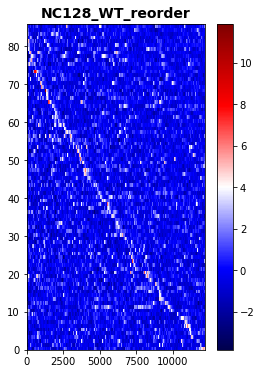

In [15]:
for i in range(len(WT_list)):
    
    mouse_name = WT_list[i]
    
    print('Processing', mouse_name)
    
    mice = os.path.join(root_path, mouse_name)
    trace = os.path.join(root_path, mouse_name, "trace.csv")
    position = os.path.join(root_path, mouse_name, "cells position.csv")
    event0 = os.path.join(root_path, mouse_name, "event0.xlsx")
    event1 = os.path.join(root_path, mouse_name, "event1.xlsx")
    event2 = os.path.join(root_path, mouse_name, "event2.xlsx")
    event3 = os.path.join(root_path, mouse_name, "event3.xlsx")
    incorrect = os.path.join(root_path_incorrect, WT_incorrect_neuron_list[i])
    
    df = process_(trace, incorrect, position) 
    df_1 = separate_session(df)[0]
    df_1_reorder = reorder_df(df_1)
    
    #-----find scale-----
    _max = max(df_1_reorder.max().values.tolist())
    _min = min(df_1_reorder.min().values.tolist())
    print(_max,_min)

    #-----plot-----
    cmap = 'seismic'
    figsize = (4,6)
    plot_colomap(df_1_reorder,mouse_name+'_reorder',cmap,figsize,vmin=_min, vmax=_max)
    
    break

